# Imports

In [1]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pprint import pprint

import joblib

%matplotlib inline

# Data

In [2]:
# read training data
train = pd.read_csv("train.csv")

# Goal
Predict `type` of creature.

In [3]:
train.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [5]:
train.set_index('id', inplace=True)

In [7]:
X = train.drop(columns='type')
y = train.type

X_obj = X.select_dtypes(include=['O'])

X_num = X.select_dtypes(exclude=['O'])

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

ohe_obj = ohe.fit_transform(X_obj)

X_obj = pd.DataFrame(
    data=ohe_obj,
    index=X_obj.index,
    columns=ohe.get_feature_names(X_obj.columns)
)

X = X_num.join(X_obj)

## Logistic Regression

In [140]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [141]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", LogisticRegression(
        dual=False,
        class_weight="balanced",
        random_state=0,
        solver="liblinear",
        multi_class="ovr",
        n_jobs=-1,
    )),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__penalty" : ["l1", "l2"],
    "clf__tol" : stats.uniform(0, 1e-2),
    "clf__C" : stats.uniform(0, 5),
    "clf__fit_intercept" : [True, False],
    "clf__max_iter" : stats.randint(100, 1000),
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.0min


Best RSCV Score: 0.7406432748538012


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.0min finished
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [142]:
from sklearn.metrics import classification_report

print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.84      0.95      0.89        57
       Ghoul       0.70      0.86      0.77        63
      Goblin       0.75      0.49      0.59        61

    accuracy                           0.76       181
   macro avg       0.77      0.77      0.75       181
weighted avg       0.76      0.76      0.75       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.75      0.96      0.84        25
       Ghoul       0.75      0.89      0.81        27
      Goblin       0.79      0.42      0.55        26

    accuracy                           0.76        78
   macro avg       0.76      0.76      0.74        78
weighted avg       0.76      0.76      0.73        78



Testing Report
-------------------------------------------

Getting coefficients

In [143]:
scale = rscv.best_estimator_.named_steps.scale

var = rscv.best_estimator_.named_steps.var

select = rscv.best_estimator_.named_steps.select

clf = rscv.best_estimator_.named_steps.clf

X_ = pd.DataFrame(
    scale.transform(X),
    index=X.index,
    columns=X.columns,
)

X_ = pd.DataFrame(
    var.transform(X_),
    index=X_.index,
    columns=X_.columns[var.get_support()]
)

X_ = pd.DataFrame(
    select.transform(X_),
    index=X_.index,
    columns=X_.columns[select.get_support()]
)

clf.fit(X_, y)

coefficients = pd.DataFrame(
    clf.coef_,
    index=clf.classes_,
    columns=X_.columns
)

coef_mask = coefficients.sum().mask(lambda x: x == 0)

coef_mask.dropna(inplace=True)

coefficients = coefficients.reindex(columns=coef_mask.index)

coefficients

/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_white
Ghost,-5.157298,6.581265,-8.627802,-7.390625,0.000000,0.874761,0.000000,0.464180,-0.004779
Ghoul,3.743242,0.000000,5.513239,5.355890,0.090002,0.000000,-0.237984,-0.215552,0.177092
Goblin,-0.011230,-3.432222,0.000000,0.000000,0.000000,-0.463539,0.172978,0.084588,-0.048672


In [144]:
joblib.dump(rscv.best_estimator_, "logreg.joblib", compress=True)

['logreg.joblib']

## SVM

In [ ]:
from sklearn.svm import SVC

In [145]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", SVC(
        probability=True,
        cache_size=200,
        class_weight="balanced",
        max_iter=-1,
        decision_function_shape="ovr",
        random_state=0,
    )),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__C" : stats.uniform(0, 5),
    "clf__kernel" : ["linear", "poly", "rbf"],
    "clf__degree" : stats.randint(3, 10),
    "clf__gamma" : ["auto", "scale"],
    "clf__coef0" : stats.uniform(-1, 2),
    "clf__shrinking" : [True, False],
    "clf__tol" : stats.uniform(0, 1e-1),
    "clf__break_ties" : [True, False],
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.3min


Best RSCV Score: 0.7350877192982456


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.3min finished


In [146]:
from sklearn.metrics import classification_report

print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.86      0.95      0.90        57
       Ghoul       0.77      0.76      0.77        63
      Goblin       0.70      0.64      0.67        61

    accuracy                           0.78       181
   macro avg       0.78      0.78      0.78       181
weighted avg       0.77      0.78      0.78       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.73      0.96      0.83        25
       Ghoul       0.85      0.81      0.83        27
      Goblin       0.74      0.54      0.62        26

    accuracy                           0.77        78
   macro avg       0.77      0.77      0.76        78
weighted avg       0.77      0.77      0.76        78



Testing Report
-------------------------------------------

Getting coefficients

In [147]:
scale = rscv.best_estimator_.named_steps.scale

var = rscv.best_estimator_.named_steps.var

select = rscv.best_estimator_.named_steps.select

clf = rscv.best_estimator_.named_steps.clf

X_ = pd.DataFrame(   
    scale.transform(X),
    index=X.index,
    columns=X.columns,
)

X_ = pd.DataFrame(
    var.transform(X_),
    index=X_.index,
    columns=X_.columns[var.get_support()]
)

X_ = pd.DataFrame(
    select.transform(X_),
    index=X_.index,
    columns=X_.columns[select.get_support()]
)

clf.fit(X_, y)

coefficients = pd.DataFrame(
    clf.coef_,
    index=clf.classes_,
    columns=X_.columns
)

coef_mask = coefficients.sum().mask(lambda x: x == 0)

coef_mask.dropna(inplace=True)

coefficients = coefficients.reindex(columns=coef_mask.index)

coefficients

,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
Ghost,-3.281277,2.825302,-6.043970,-5.586651,0.114463,0.644548,-0.868851,0.071139,0.449101,-0.410400
Ghoul,-3.961083,4.802137,-6.436560,-4.313558,-0.521987,1.387312,-0.596093,0.268998,-0.124179,-0.414051
Goblin,3.265254,0.815707,4.341685,4.354775,0.615091,-0.293558,-0.772413,-0.026535,0.141711,0.335705


In [148]:
joblib.dump(rscv.best_estimator_, "svm.joblib", compress=True)

['svm.joblib']

## AdaBoost

In [150]:
from sklearn.ensemble import AdaBoostClassifier

In [160]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", AdaBoostClassifier(
        base_estimator=None,
        random_state=0,
    )),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__n_estimators" : stats.randint(50, 1000),
    "clf__learning_rate" : stats.uniform(1e-2, 2.5),
    "clf__algorithm" : ["SAMME", "SAMME.R"],
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=10,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:   45.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.6s finished


Best RSCV Score: 0.6467836257309941


In [161]:
from sklearn.metrics import classification_report

print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.98      1.00      0.99        57
       Ghoul       0.77      0.97      0.86        63
      Goblin       0.95      0.69      0.80        61

    accuracy                           0.88       181
   macro avg       0.90      0.89      0.88       181
weighted avg       0.90      0.88      0.88       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.85      0.88      0.86        25
       Ghoul       0.77      0.85      0.81        27
      Goblin       0.68      0.58      0.62        26

    accuracy                           0.77        78
   macro avg       0.76      0.77      0.76        78
weighted avg       0.76      0.77      0.76        78



Testing Report
-------------------------------------------

Getting coefficients

In [147]:
scale = rscv.best_estimator_.named_steps.scale

var = rscv.best_estimator_.named_steps.var

select = rscv.best_estimator_.named_steps.select

clf = rscv.best_estimator_.named_steps.clf

X_ = pd.DataFrame(   
    scale.transform(X),
    index=X.index,
    columns=X.columns,
)

X_ = pd.DataFrame(
    var.transform(X_),
    index=X_.index,
    columns=X_.columns[var.get_support()]
)

X_ = pd.DataFrame(
    select.transform(X_),
    index=X_.index,
    columns=X_.columns[select.get_support()]
)

clf.fit(X_, y)

coefficients = pd.DataFrame(
    clf.coef_,
    index=clf.classes_,
    columns=X_.columns
)

coef_mask = coefficients.sum().mask(lambda x: x == 0)

coef_mask.dropna(inplace=True)

coefficients = coefficients.reindex(columns=coef_mask.index)

coefficients

,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
Ghost,-3.281277,2.825302,-6.043970,-5.586651,0.114463,0.644548,-0.868851,0.071139,0.449101,-0.410400
Ghoul,-3.961083,4.802137,-6.436560,-4.313558,-0.521987,1.387312,-0.596093,0.268998,-0.124179,-0.414051
Goblin,3.265254,0.815707,4.341685,4.354775,0.615091,-0.293558,-0.772413,-0.026535,0.141711,0.335705


In [148]:
joblib.dump(rscv.best_estimator_, "svm.joblib", compress=True)

['svm.joblib']

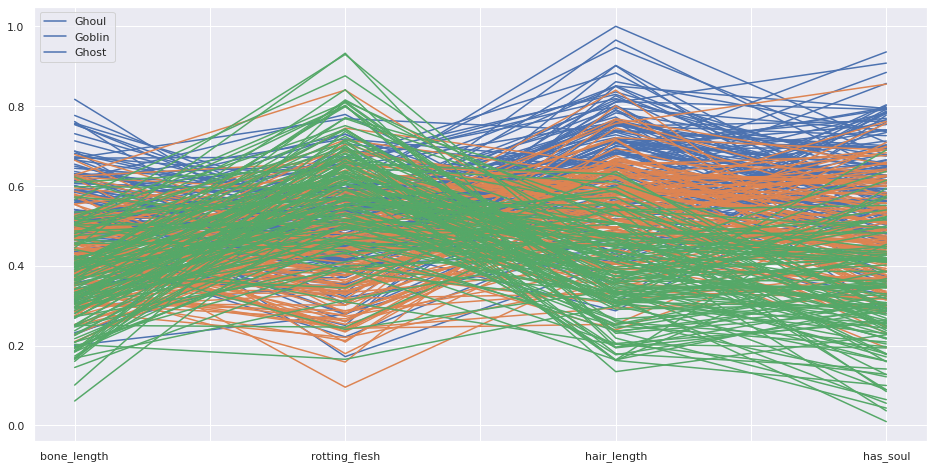

In [137]:
fig, ax = plt.subplots(figsize=(16,8))

h,l = [], []

for i,g in enumerate(train.type.unique()):
    
    _ = train.loc[train.type == g, :'has_soul'].copy()
    _ = _.T.copy()
    
    _.plot(label=g, c=sns.color_palette()[i], ax=ax)
    
    h_, l_ = ax.get_legend_handles_labels()
    h.append(h_[0])
    l.append(g)

ax.legend(h,l)

In [686]:
train.loc[
    (train.bone_length_Ghost_iqr == True)
    & (train.hair_length_Ghost_iqr == True)
    & (train.has_soul_Ghost_iqr == True)
    & (train.rotting_flesh_Ghost_iqr == True)
#     & (train.bone_length_Ghoul_iqr == False)
#     & (train.bone_length_Goblin_iqr == False)
#     & (train.)
].type.value_counts(normalize=True)

Ghost     0.888889
Goblin    0.111111
Name: type, dtype: float64

In [712]:
train.loc[
    (train.bone_length_Goblin_iqr == True)
    & (train.hair_length_Goblin_iqr == True)
    & (train.has_soul_Goblin_iqr == True)
    & (train.rotting_flesh_Goblin_iqr == True)
#     & (train.bone_length_Ghoul_iqr == False)
#     & (train.bone_length_Goblin_iqr == False)
#     & (train.)
].type.value_counts(normalize=True)

Goblin    0.769231
Ghoul     0.153846
Ghost     0.076923
Name: type, dtype: float64

In [689]:
train.loc[
    (train.bone_length_Ghost_iqr == True)
    & (train.hair_length_Ghost_iqr == True)
    & (train.has_soul_Ghost_iqr == True)
    & (train.rotting_flesh_Ghost_iqr == True)
]

,bone_length,rotting_flesh,hair_length,has_soul,color,type,bone_length_Ghost_iqr,bone_length_Ghoul_iqr,bone_length_Goblin_iqr,rotting_flesh_Ghost_iqr,rotting_flesh_Ghoul_iqr,rotting_flesh_Goblin_iqr,hair_length_Ghost_iqr,hair_length_Ghoul_iqr,hair_length_Goblin_iqr,has_soul_Ghost_iqr,has_soul_Ghoul_iqr,has_soul_Goblin_iqr
id,,,,,,,,,,,,,,,,,,
262,0.298797,0.553370,0.306682,0.360853,white,Ghost,True,False,False,True,True,False,True,False,False,True,False,False
265,0.317938,0.652680,0.390057,0.293632,green,Ghost,True,False,False,True,False,False,True,False,False,True,False,False
272,0.365032,0.524358,0.328400,0.325906,white,Ghost,True,False,True,True,True,True,True,False,False,True,False,False
324,0.297148,0.531544,0.312002,0.382700,clear,Goblin,True,False,False,True,True,False,True,False,False,True,False,True
419,0.327031,0.608481,0.310469,0.356699,green,Ghost,True,False,False,True,False,False,True,False,False,True,False,False
435,0.340442,0.531701,0.428498,0.263063,white,Ghost,True,False,False,True,True,False,True,False,False,True,False,False
590,0.367799,0.637446,0.416354,0.415930,clear,Ghost,True,False,True,True,False,False,True,False,False,True,False,True
686,0.332134,0.577321,0.445860,0.409526,clear,Ghost,True,False,False,True,False,False,True,False,False,True,False,True
699,0.417253,0.624973,0.328752,0.279668,blood,Ghost,True,False,True,True,False,False,True,False,False,True,False,False


In [713]:
train.loc[
    (train.bone_length_Goblin_iqr == True)
    & (train.hair_length_Goblin_iqr == True)
    & (train.has_soul_Goblin_iqr == True)
    & (train.rotting_flesh_Goblin_iqr == True)
#     & (train.bone_length_Ghoul_iqr == False)
#     & (train.bone_length_Goblin_iqr == False)
#     & (train.)
]

,bone_length,rotting_flesh,hair_length,has_soul,color,type,bone_length_Ghost_iqr,bone_length_Ghoul_iqr,bone_length_Goblin_iqr,rotting_flesh_Ghost_iqr,rotting_flesh_Ghoul_iqr,rotting_flesh_Goblin_iqr,hair_length_Ghost_iqr,hair_length_Ghoul_iqr,hair_length_Goblin_iqr,has_soul_Ghost_iqr,has_soul_Ghoul_iqr,has_soul_Goblin_iqr
id,,,,,,,,,,,,,,,,,,
170,0.480836,0.407930,0.539005,0.495069,clear,Goblin,False,True,True,False,False,True,False,False,True,False,False,True
266,0.489132,0.481304,0.482691,0.460081,white,Goblin,False,True,True,False,True,True,False,False,True,False,False,True
389,0.389928,0.402729,0.474255,0.419319,white,Goblin,True,False,True,False,False,True,False,False,True,False,False,True
514,0.396298,0.460407,0.515815,0.476212,white,Goblin,True,False,True,False,True,True,False,False,True,False,False,True
582,0.451085,0.464508,0.505819,0.509010,black,Goblin,False,True,True,False,True,True,False,False,True,False,True,True
617,0.404424,0.464504,0.504417,0.409003,clear,Ghost,True,False,True,False,True,True,False,False,True,True,False,True
661,0.491710,0.463629,0.559444,0.435188,clear,Goblin,False,True,True,False,True,True,False,True,True,False,False,True
662,0.403727,0.364366,0.609004,0.487301,white,Goblin,True,False,True,False,False,True,False,True,True,False,False,True
739,0.444006,0.424189,0.549613,0.447517,green,Goblin,False,True,True,False,True,True,False,False,True,False,False,True


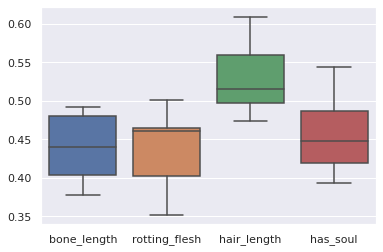

In [723]:
sns.boxplot(
    data = train.loc[
        (train.bone_length_Goblin_iqr == True)
        & (train.hair_length_Goblin_iqr == True)
        & (train.has_soul_Goblin_iqr == True)
        & (train.rotting_flesh_Goblin_iqr == True),
        :'type'
    ],
#     hue='type',
#     y='bone_length',
#     x='color',
)

In [717]:
train.loc[
    (train.bone_length_Goblin_iqr == True)
    & (train.hair_length_Goblin_iqr == True)
    & (train.has_soul_Goblin_iqr == True)
    & (train.rotting_flesh_Goblin_iqr == True)
].groupby([
    'color',
    'type',
]).bone_length.describe().

count      mean       std       min       25%       50%  \
color type                                                              
black Goblin    1.0  0.451085       NaN  0.451085  0.451085  0.451085   
clear Ghost     1.0  0.404424       NaN  0.404424  0.404424  0.404424   
      Ghoul     1.0  0.481640       NaN  0.481640  0.481640  0.481640   
      Goblin    4.0  0.447532  0.051727  0.377449  0.424462  0.460484   
green Goblin    1.0  0.444006       NaN  0.444006  0.444006  0.444006   
white Ghoul     1.0  0.417776       NaN  0.417776  0.417776  0.417776   
      Goblin    4.0  0.419771  0.046583  0.389928  0.394705  0.400013   

                   75%       max  
color type                        
black Goblin  0.451085  0.451085  
clear Ghost   0.404424  0.404424  
      Ghoul   0.481640  0.481640  
      Goblin  0.483554  0.491710  
green Goblin  0.444006  0.444006  
white Ghoul   0.417776  0.417776  
      Goblin  0.425079  0.489132

In [690]:
train.loc[324]

bone_length                 0.297148
rotting_flesh               0.531544
hair_length                 0.312002
has_soul                      0.3827
color                          clear
type                          Goblin
bone_length_Ghost_iqr           True
bone_length_Ghoul_iqr          False
bone_length_Goblin_iqr         False
rotting_flesh_Ghost_iqr         True
rotting_flesh_Ghoul_iqr         True
rotting_flesh_Goblin_iqr       False
hair_length_Ghost_iqr           True
hair_length_Ghoul_iqr          False
hair_length_Goblin_iqr         False
has_soul_Ghost_iqr              True
has_soul_Ghoul_iqr             False
has_soul_Goblin_iqr             True
Name: 324, dtype: object

In [699]:
train.loc[
    (train.bone_length_Ghost_iqr == True)
    & (train.hair_length_Ghost_iqr == True)
    & (train.has_soul_Ghost_iqr == True)
    & (train.rotting_flesh_Ghost_iqr == True),
    :'has_soul'
].agg(['mean', 'median', 'sum'], axis=1)

,mean,median,sum
262,0.379926,0.333768,1.519703
265,0.413577,0.353998,1.654307
272,0.385924,0.346716,1.543697
324,0.380848,0.347351,1.523393
419,0.400670,0.341865,1.602680
435,0.390926,0.384470,1.563704
590,0.459382,0.416142,1.837529
686,0.441210,0.427693,1.764840
699,0.412661,0.373002,1.650646


In [694]:
train.loc[
    (train.bone_length_Ghost_iqr == True)
    & (train.hair_length_Ghost_iqr == True)
    & (train.has_soul_Ghost_iqr == True)
    & (train.rotting_flesh_Ghost_iqr == True),
    :'has_soul'
].quantile([0.25, 0.75], axis=1)

id,262,265,272,324,419,435,590,686,699
0.25,0.304711,0.311862,0.327777,0.308288,0.322891,0.321097,0.403897,0.390178,0.316481
0.75,0.408983,0.455713,0.404864,0.419911,0.419644,0.454299,0.471627,0.478725,0.469183


In [701]:
train.loc[
    (train.bone_length_Ghost_iqr == True)
    & (train.hair_length_Ghost_iqr == True)
    & (train.has_soul_Ghost_iqr == True)
    & (train.rotting_flesh_Ghost_iqr == True),
    :'has_soul'
]

,bone_length,rotting_flesh,hair_length,has_soul
id,,,,
262,0.298797,0.553370,0.306682,0.360853
265,0.317938,0.652680,0.390057,0.293632
272,0.365032,0.524358,0.328400,0.325906
324,0.297148,0.531544,0.312002,0.382700
419,0.327031,0.608481,0.310469,0.356699
435,0.340442,0.531701,0.428498,0.263063
590,0.367799,0.637446,0.416354,0.415930
686,0.332134,0.577321,0.445860,0.409526
699,0.417253,0.624973,0.328752,0.279668


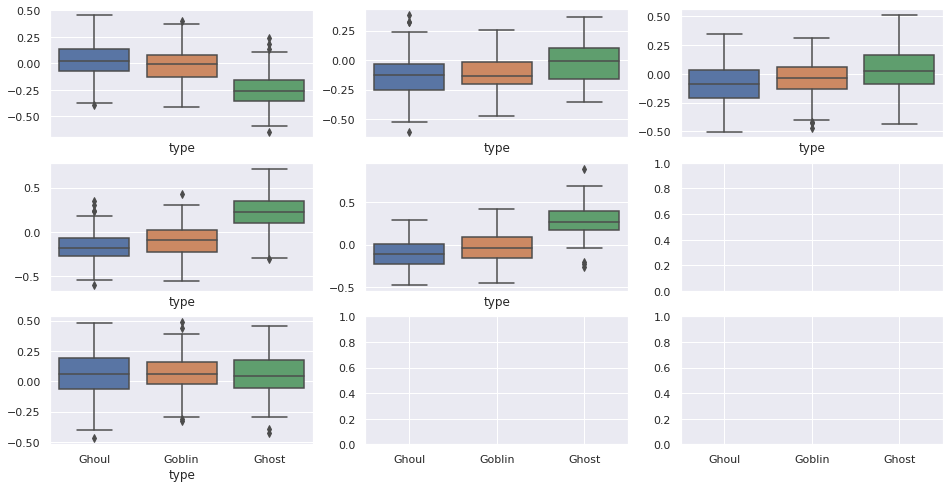

In [711]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(16,8), sharex=True)

sns.boxplot(
    y=train.bone_length - train.rotting_flesh,
    x=train.type,
    ax=ax[0,0]
)
sns.boxplot(
    y=train.bone_length - train.hair_length,
    x=train.type,
    ax=ax[0,1]
)
sns.boxplot(
    y=train.bone_length - train.has_soul,
    x=train.type,
    ax=ax[0,2]
)
sns.boxplot(
    y=train.rotting_flesh - train.hair_length,
    x=train.type,
    ax=ax[1,0]
)
sns.boxplot(
    y=train.rotting_flesh - train.has_soul,
    x=train.type,
    ax=ax[1,1]
)
sns.boxplot(
    y=train.hair_length - train.has_soul,
    x=train.type,
    ax=ax[2,0]
)

- If `Goblin` is below median in one feature, is it below median in other features? What about other types?

Model always does poorly on `Goblins`. What separates `Goblins` from `Ghouls` and `Ghosts`?

Build model to separate `Goblins` from the other two. Or at least determine important features.

Each `type` has a central point in each feature... Make 3 sub-features per feature (1 for each `type`) showing distance from center (median)

In [618]:
q = train.groupby('type').quantile([0.25, 0.5, 0.75])

In [621]:
q

bone_length  rotting_flesh  hair_length  has_soul
type                                                          
Ghost  0.25     0.269748       0.504399     0.299507  0.230361
       0.50     0.340442       0.603780     0.365142  0.307534
       0.75     0.417253       0.682687     0.461068  0.415930
Ghoul  0.25     0.439625       0.417474     0.556691  0.501544
       0.50     0.515397       0.491497     0.667384  0.600393
       0.75     0.590384       0.561786     0.751614  0.698480
Goblin 0.25     0.355313       0.341187     0.474255  0.377121
       0.50     0.430797       0.457490     0.558776  0.466024
       0.75     0.492438       0.530852     0.621787  0.557136

In [631]:
train['bone_length_Ghost_iqr'] = train.bone_length.between(q.loc[('Ghost', 0.25), 'bone_length'], q.loc[('Ghost', 0.75), 'bone_length'])

train['bone_length_Ghoul_iqr'] = train.bone_length.between(q.loc[('Ghoul', 0.25), 'bone_length'], q.loc[('Ghoul', 0.75), 'bone_length'])

train['bone_length_Goblin_iqr'] = train.bone_length.between(q.loc[('Goblin', 0.25), 'bone_length'], q.loc[('Goblin', 0.75), 'bone_length'])

train['rotting_flesh_Ghost_iqr'] = train.rotting_flesh.between(q.loc[('Ghost', 0.25), 'rotting_flesh'], q.loc[('Ghost', 0.75), 'rotting_flesh'])

train['rotting_flesh_Ghoul_iqr'] = train.rotting_flesh.between(q.loc[('Ghoul', 0.25), 'rotting_flesh'], q.loc[('Ghoul', 0.75), 'rotting_flesh'])

train['rotting_flesh_Goblin_iqr'] = train.rotting_flesh.between(q.loc[('Goblin', 0.25), 'rotting_flesh'], q.loc[('Goblin', 0.75), 'rotting_flesh'])

train['hair_length_Ghost_iqr'] = train.hair_length.between(q.loc[('Ghost', 0.25), 'hair_length'], q.loc[('Ghost', 0.75), 'hair_length'])

train['hair_length_Ghoul_iqr'] = train.hair_length.between(q.loc[('Ghoul', 0.25), 'hair_length'], q.loc[('Ghoul', 0.75), 'hair_length'])

train['hair_length_Goblin_iqr'] = train.hair_length.between(q.loc[('Goblin', 0.25), 'hair_length'], q.loc[('Goblin', 0.75), 'hair_length'])

train['has_soul_Ghost_iqr'] = train.has_soul.between(q.loc[('Ghost', 0.25), 'has_soul'], q.loc[('Ghost', 0.75), 'has_soul'])

train['has_soul_Ghoul_iqr'] = train.has_soul.between(q.loc[('Ghoul', 0.25), 'has_soul'], q.loc[('Ghoul', 0.75), 'has_soul'])

train['has_soul_Goblin_iqr'] = train.has_soul.between(q.loc[('Goblin', 0.25), 'has_soul'], q.loc[('Goblin', 0.75), 'has_soul'])

In [639]:
train.columns

Index(['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'color',
       'type', 'bone_length_Ghost_iqr', 'bone_length_Ghoul_iqr',
       'bone_length_Goblin_iqr', 'rotting_flesh_Ghost_iqr',
       'rotting_flesh_Ghoul_iqr', 'rotting_flesh_Goblin_iqr',
       'hair_length_Ghost_iqr', 'hair_length_Ghoul_iqr',
       'hair_length_Goblin_iqr', 'has_soul_Ghost_iqr', 'has_soul_Ghoul_iqr',
       'has_soul_Goblin_iqr'],
      dtype='object')

In [657]:
train.groupby([
    'bone_length_Ghost_iqr',
    'bone_length_Ghoul_iqr',
    'bone_length_Goblin_iqr',
    'rotting_flesh_Ghost_iqr',
    'rotting_flesh_Ghoul_iqr',
    'rotting_flesh_Goblin_iqr',
    'hair_length_Ghost_iqr',
    'hair_length_Ghoul_iqr',
    'hair_length_Goblin_iqr',
    'has_soul_Ghost_iqr',
    'has_soul_Ghoul_iqr',
    'has_soul_Goblin_iqr',
    'type',
]).type.count().unstack(fill_value=0).style.background_gradient()

In [613]:
train.loc[:, :'has_soul'].mean(axis=1).to_frame('avg').join(train.type)

,avg,type
id,,
0,0.488063,Ghoul
1,0.493182,Goblin
2,0.606262,Ghoul
4,0.701651,Ghoul
5,0.624252,Ghost
...,...,...
886,0.536543,Goblin
889,0.496864,Ghost
890,0.505809,Ghoul


In [609]:
train.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
id,,,,,,
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [579]:
# train['ghost_bone_length_dist'] = train.bone_length - train.groupby('type').bone_length.median().loc['Ghost']

# train['ghoul_bone_length_dist'] = train.bone_length - train.groupby('type').bone_length.median().loc['Ghoul']

# train['goblin_bone_length_dist'] = train.bone_length - train.groupby('type').bone_length.median().loc['Goblin']

# train['ghost_rotting_flesh_dist'] = train.rotting_flesh - train.groupby('type').rotting_flesh.median().loc['Ghost']

# train['ghoul_rotting_flesh_dist'] = train.rotting_flesh - train.groupby('type').rotting_flesh.median().loc['Ghoul']

# train['goblin_rotting_flesh_dist'] = train.rotting_flesh - train.groupby('type').rotting_flesh.median().loc['Goblin']

# train['ghost_hair_length_dist'] = train.hair_length - train.groupby('type').hair_length.median().loc['Ghost']

# train['ghoul_hair_length_dist'] = train.hair_length - train.groupby('type').hair_length.median().loc['Ghoul']

# train['goblin_hair_length_dist'] = train.hair_length - train.groupby('type').hair_length.median().loc['Goblin']

# train['ghost_has_soul_dist'] = train.has_soul - train.groupby('type').has_soul.median().loc['Ghost']

# train['ghoul_has_soul_dist'] = train.has_soul - train.groupby('type').has_soul.median().loc['Ghoul']

# train['goblin_has_soul_dist'] = train.has_soul - train.groupby('type').has_soul.median().loc['Goblin']has_soul

In [591]:
train

,bone_length,rotting_flesh,hair_length,has_soul,color,type,ghost_bone_length_dist,ghoul_bone_length_dist,goblin_bone_length_dist,ghost_rotting_flesh_dist,ghoul_rotting_flesh_dist,goblin_rotting_flesh_dist,ghost_hair_length_dist,ghoul_hair_length_dist,goblin_hair_length_dist,ghost_has_soul_dist,ghoul_has_soul_dist,goblin_has_soul_dist
id,,,,,,,,,,,,,,,,,,
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,0.014070,-0.160885,-0.076285,-0.252941,-0.140658,-0.106651,0.100619,-0.201623,-0.093016,0.473608,0.180749,0.315118
1,0.575560,0.425868,0.531401,0.439899,green,Goblin,0.235118,0.060163,0.144763,-0.177911,-0.065628,-0.031621,0.166259,-0.135982,-0.027375,0.132365,-0.160494,-0.026125
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,0.127433,-0.047522,0.037078,-0.249449,-0.137166,-0.103159,0.446474,0.144232,0.252840,0.483691,0.190832,0.325201
4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,0.436210,0.261255,0.345855,-0.095057,0.017226,0.051233,0.271624,-0.030618,0.077989,0.576930,0.284071,0.418440
5,0.566117,0.875862,0.418594,0.636438,green,Ghost,0.225674,0.050719,0.135320,0.272082,0.384365,0.418372,0.053452,-0.248790,-0.140183,0.328904,0.036045,0.170414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.458132,0.391760,0.660590,0.635689,blue,Goblin,0.117690,-0.057265,0.027335,-0.212020,-0.099737,-0.065730,0.295448,-0.006794,0.101813,0.328155,0.035296,0.169665
889,0.331936,0.564836,0.539216,0.551471,green,Ghost,-0.008506,-0.183461,-0.098861,-0.038944,0.073339,0.107346,0.174073,-0.128168,-0.019561,0.243937,-0.048922,0.085446
890,0.481640,0.501147,0.496446,0.544003,clear,Ghoul,0.141198,-0.033757,0.050843,-0.102633,0.009650,0.043657,0.131304,-0.170937,-0.062330,0.236469,-0.056390,0.077979


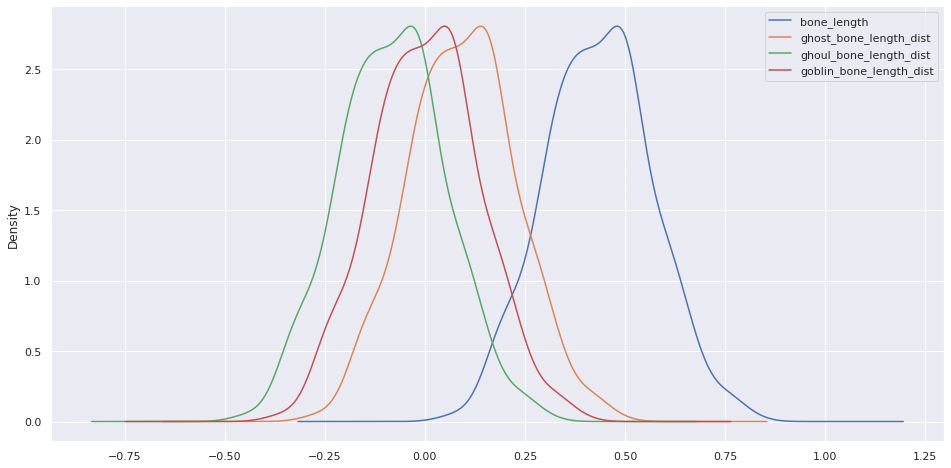

In [586]:
pd.concat([train.bone_length, train.loc[:, 'ghost_bone_length_dist':]], axis=1).plot.kde(figsize=(16,8))

In [485]:
goblin = train.copy()

goblin["type"] = goblin.type.apply(lambda x : "Goblin" if x == "Goblin" else "Not Goblin")

In [494]:
goblin_X = goblin.drop(columns='type')
goblin_y = goblin.type

goblin_X_obj = goblin_X.select_dtypes(include=['O'])

goblin_X_num = goblin_X.select_dtypes(exclude=['O'])

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

ohe_obj = ohe.fit_transform(goblin_X_obj)

goblin_X_obj = pd.DataFrame(
    data=ohe_obj,
    index=goblin_X_obj.index,
    columns=ohe.get_feature_names(goblin_X_obj.columns)
)

goblin_X = goblin_X_num.join(goblin_X_obj)

from sklearn.tree import DecisionTreeClassifier

In [534]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [535]:
goblin_X = pd.DataFrame(
    poly.fit_transform(goblin_X),
    index=goblin_X.index,
    columns=poly.get_feature_names(goblin_X.columns)
)

In [571]:
dc_rscv = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=0),
    param_distributions={
        'criterion' : ['gini', 'entropy',],
        'splitter' : ['best', 'random',],
        'max_depth' : [stats.randint(1, 100), None],
        'min_samples_split' : stats.uniform(0, 0.08),
        'min_samples_leaf' : stats.uniform(0, 0.008),
        'min_weight_fraction_leaf' : stats.uniform(0, 0.006),
        'max_features' : ['sqrt', 'log2', None],
        'max_leaf_nodes' : [stats.randint(1, 100), None],
        'min_impurity_decrease' : stats.uniform(0, 0.01),
        'ccp_alpha' : stats.uniform(0, 0.1)
    },
    n_iter=2000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0
)

dc_rscv.fit(goblin_X.reindex(columns=["hair_length", "has_soul"]), goblin_y)

print(f"Best Params")
print('-'*77)
print() 
pprint(dc_rscv.best_params_)
print()
print('-'*77)
print()
print(f"Best Training Score: {dc_rscv.best_score_}")
print()
print('-'*77)
print()
print(f"Training Score: ", dc_rscv.score(goblin_X.reindex(columns=["hair_length", "has_soul"]), goblin_y))
print()
print(classification_report(goblin_y, dc_rscv.predict(goblin_X.reindex(columns=["hair_length", "has_soul"]))))

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 6380 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 11980 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 19180 tasks      | elapsed:  1.1min


Best Params
-----------------------------------------------------------------------------

{'ccp_alpha': 0.002453235549924082,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.007965718467424315,
 'min_samples_leaf': 0.0006523485809160192,
 'min_samples_split': 0.04140609537221449,
 'min_weight_fraction_leaf': 0.0006822962134288768,
 'splitter': 'best'}

-----------------------------------------------------------------------------

Best Training Score: 0.6982930298719773

-----------------------------------------------------------------------------

Training Score:  0.7493261455525606

              precision    recall  f1-score   support

      Goblin       0.61      0.73      0.66       125
  Not Goblin       0.85      0.76      0.80       246

    accuracy                           0.75       371
   macro avg       0.73      0.74      0.73       371
weighted avg       0.77      0.75      0.75       371



[Parallel(n_jobs=-1)]: Done 20000 out of 20000 | elapsed:  1.1min finished


In [573]:
pd.Series(dc_rscv.best_estimator_.feature_importances_, index=goblin_X.reindex(columns=["hair_length", "has_soul"]).columns).sort_values(ascending=False)

has_soul       0.509153
hair_length    0.490847
dtype: float64

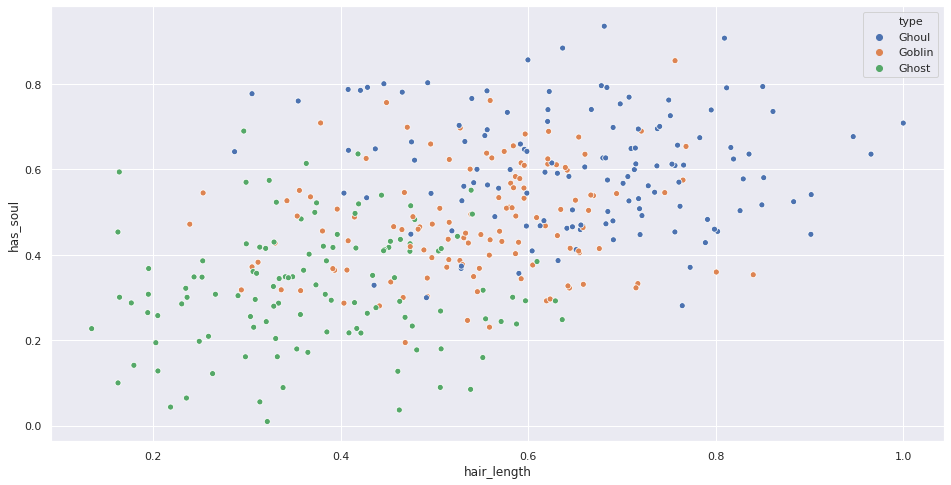

In [546]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(
    data=train,
    x='hair_length',
    y='has_soul',
    hue='type',
    ax=ax
)

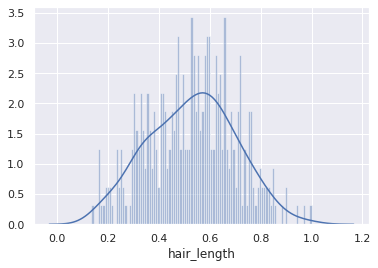

In [547]:
sns.distplot(
    a=train.hair_length,
    bins=100
)

In [341]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [353]:
test = pd.DataFrame(
    data=poly.fit_transform(X),
    index=X.index,
    columns=poly.get_feature_names(X.columns)
).drop(columns=X.columns)

In [361]:
test = test.reindex(columns=test.columns[test.columns.str.count('color') == 1])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

In [362]:
X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.3, stratify=y, random_state=0)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

## Ada (test)

In [380]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures()),
    ('scale', StandardScaler()),
    ('non_neg', MinMaxScaler()),
    ('var', VarianceThreshold()),
    ('select', SelectPercentile()),
    ('clf', GradientBoostingClassifier(random_state=0))
])

params_pre = {
    'poly__degree' : stats.randint(2, 6),
    'poly__interaction_only' : [True, False],
    'poly__include_bias' : [True, False],
    'scale__with_mean' : [True, False],
    'scale__with_std' : [True, False],
    'var__threshold' : stats.uniform(0, 0.015),
    'select__score_func' : [f_classif, chi2, mutual_info_classif],
    'select__percentile' : stats.randint(20, 100),
}

In [381]:
params = [
    {
        **params_pre,
        'clf' : [OneVsRestClassifier(AdaBoostClassifier(random_state=0), n_jobs=-1)],
        'clf__estimator__n_estimators' : stats.randint(50, 1000),
        'clf__estimator__learning_rate' : stats.uniform(0.5, 1.5),
        'clf__estimator__algorithm' : ['SAMME', 'SAMME.R'],
    }
]

ada_test_rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

In [382]:
ada_test_rscv.fit(X_train, y_train)
print(f"Best Params")
print('-'*77)
print()
pprint(ada_test_rscv.best_params_)
print()
print('-'*77)
print()
print(f"Best Training Score: {ada_test_rscv.best_score_}")
print()
print('-'*77)
print()
print(f"Training Score: {ada_test_rscv.score(X_train, y_train)}")
print()
print(classification_report(y_train, ada_test_rscv.predict(X_train)))
print()
print('-'*77)
print()
print(f"Validation Score: {ada_test_rscv.score(X_validate, y_validate)}")
print()
print(classification_report(y_validate, ada_test_rscv.predict(X_validate)))
print()
print('-'*77)
print()
print(f"Test Score: {ada_test_rscv.score(X_test, y_test)}")
print()
print(classification_report(y_test, ada_test_rscv.predict(X_test)))
print()

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 3045.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 3057.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 3068.9min finished


Best Params
-----------------------------------------------------------------------------

{'clf': OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=1.3892669273375275,
                                                 n_estimators=242,
                                                 random_state=0),
                    n_jobs=-1),
 'clf__estimator__algorithm': 'SAMME',
 'clf__estimator__learning_rate': 1.3892669273375275,
 'clf__estimator__n_estimators': 242,
 'poly__degree': 5,
 'poly__include_bias': False,
 'poly__interaction_only': False,
 'scale__with_mean': False,
 'scale__with_std': False,
 'select__percentile': 41,
 'select__score_func': <function mutual_info_classif at 0x7fd09a6ed290>,
 'var__threshold': 0.006563808168940388}

-----------------------------------------------------------------------------

Best Training Score: 0.5850877192982457

-----------------------------------------------------

In [383]:
ada_test_cv_results = pd.DataFrame(ada_test_rscv.cv_results_)

param_cols = ada_test_cv_results.columns[ada_test_cv_results.columns.str.contains('param')]

split_cols = ada_test_cv_results.columns[ada_test_cv_results.columns.str.contains('split')]

time_cols = ada_test_cv_results.columns[ada_test_cv_results.columns.str.contains('time')]

test_cols = ada_test_cv_results.columns[
    (ada_test_cv_results.columns.str.contains('test')) & (ada_test_cv_results.columns.isin(split_cols) == False)
]

param_cols = param_cols.drop([
    'params',
    'param_clf',
])

ada_test_cv_results = ada_test_cv_results.reindex(columns=param_cols.append(test_cols))

In [384]:
def cfloat(series):
    try:
        return series.astype(float)
    except Exception:
        return series

In [385]:
ada_test_cv_results = ada_test_cv_results.apply(lambda x : cfloat(x))

In [386]:
ada_test_cv_results.corr().mean_test_score.iloc[:-3].sort_values()

param_poly__interaction_only          -0.282430
param_var__threshold                  -0.204338
param_clf__estimator__n_estimators    -0.103644
param_poly__include_bias              -0.061460
param_scale__with_std                  0.014726
param_scale__with_mean                 0.047316
param_select__percentile               0.085212
param_clf__estimator__learning_rate    0.098254
param_poly__degree                     0.247733
Name: mean_test_score, dtype: float64

In [387]:
ada_test_cv_results.nunique().where(lambda x : x <= 10).dropna()

param_clf__estimator__algorithm    2.0
param_poly__degree                 4.0
param_poly__include_bias           2.0
param_poly__interaction_only       2.0
param_scale__with_mean             2.0
param_scale__with_std              2.0
param_select__score_func           3.0
dtype: float64

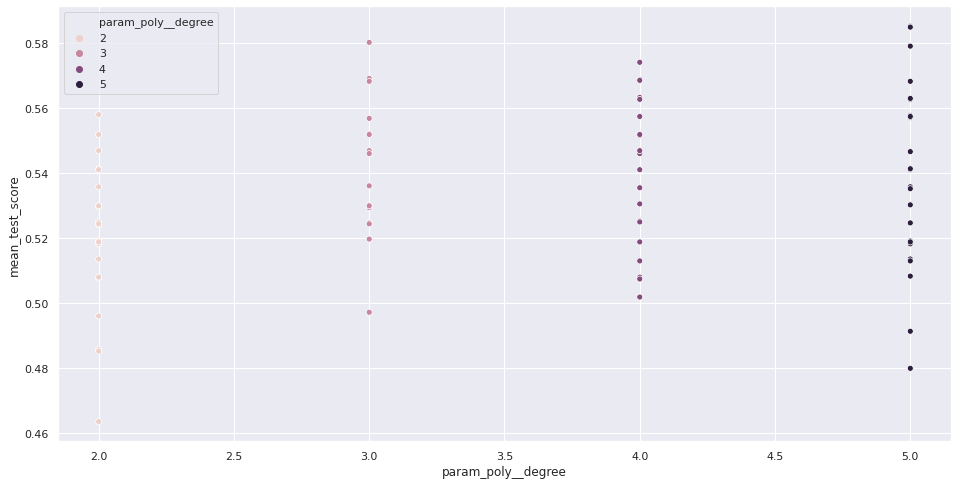

In [391]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(
    data=ada_test_cv_results,
    x='param_poly__degree',
    y='mean_test_score',
    hue='param_poly__degree',
    ax=ax
)

In [46]:
joblib.dump(ada_test_rscv, 'ada_test.joblib', compress=True)

['ada.joblib']

## Ada

In [402]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures()),
    ('scale', StandardScaler()),
    ('transform', ColumnTransformer(
        transformers=[('pca', PCA(n_components=1, random_state=0), ['bone_length', 'hair_length', 'has_soul'])],
        remainder='passthrough',
        n_jobs=-1
    )),
    ('non_neg', MinMaxScaler()),
    ('var', VarianceThreshold()),
    ('select', SelectPercentile()),
    ('clf', GradientBoostingClassifier(random_state=0))
])

params_pre = {
    'poly__degree' : stats.randint(2, 6),
    'poly__interaction_only' : [True, False],
    'poly__include_bias' : [True, False],
    'scale__with_mean' : [True, False],
    'scale__with_std' : [True, False],
    'var__threshold' : stats.uniform(0, 0.04),
    'select__score_func' : [f_classif, chi2, mutual_info_classif],
    'select__percentile' : stats.randint(10, 100),
}

In [32]:
params = [
    {
        **params_pre,
        'clf' : [OneVsRestClassifier(AdaBoostClassifier(random_state=0), n_jobs=-1)],
        'clf__estimator__n_estimators' : stats.randint(50, 1000),
        'clf__estimator__learning_rate' : stats.uniform(0.5, 1.5),
        'clf__estimator__algorithm' : ['SAMME', 'SAMME.R'],
    }
]

ada_rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

In [33]:
ada_rscv.fit(X_train, y_train)
print(f"Best Params")
print('-'*77)
print()
pprint(ada_rscv.best_params_)
print()
print('-'*77)
print()
print(f"Best Training Score: {ada_rscv.best_score_}")
print()
print('-'*77)
print()
print(f"Training Score: {ada_rscv.score(X_train, y_train)}")
print()
print(classification_report(y_train, ada_rscv.predict(X_train)))
print()
print('-'*77)
print()
print(f"Validation Score: {ada_rscv.score(X_validate, y_validate)}")
print()
print(classification_report(y_validate, ada_rscv.predict(X_validate)))
print()
print('-'*77)
print()
print(f"Test Score: {ada_rscv.score(X_test, y_test)}")
print()
print(classification_report(y_test, ada_rscv.predict(X_test)))
print()

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 32.2min finished


Best Params
-----------------------------------------------------------------------------

{'clf': OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=1.0227139835502457,
                                                 n_estimators=70,
                                                 random_state=0),
                    n_jobs=-1),
 'clf__estimator__algorithm': 'SAMME',
 'clf__estimator__learning_rate': 1.0227139835502457,
 'clf__estimator__n_estimators': 70,
 'poly__degree': 5,
 'poly__include_bias': True,
 'poly__interaction_only': True,
 'scale__with_mean': True,
 'scale__with_std': False,
 'select__percentile': 76,
 'select__score_func': <function chi2 at 0x7fd09acd77a0>,
 'var__threshold': 0.027084575993328724}

-----------------------------------------------------------------------------

Best Training Score: 0.7014619883040936

-------------------------------------------------------------------------

In [34]:
ada_cv_results = pd.DataFrame(ada_rscv.cv_results_)

param_cols = ada_cv_results.columns[ada_cv_results.columns.str.contains('param')]

split_cols = ada_cv_results.columns[ada_cv_results.columns.str.contains('split')]

time_cols = ada_cv_results.columns[ada_cv_results.columns.str.contains('time')]

test_cols = ada_cv_results.columns[
    (ada_cv_results.columns.str.contains('test')) & (ada_cv_results.columns.isin(split_cols) == False)
]

param_cols = param_cols.drop([
    'params',
    'param_clf',
])

ada_cv_results = ada_cv_results.reindex(columns=param_cols.append(test_cols))

In [35]:
def cfloat(series):
    try:
        return series.astype(float)
    except Exception:
        return series

In [36]:
ada_cv_results = ada_cv_results.apply(lambda x : cfloat(x))

In [37]:
ada_cv_results.corr().mean_test_score.iloc[:-3].sort_values()

param_clf__estimator__n_estimators    -0.185631
param_select__percentile              -0.132092
param_scale__with_std                 -0.027200
param_clf__estimator__learning_rate   -0.013619
param_scale__with_mean                -0.010347
param_var__threshold                   0.076139
param_poly__include_bias               0.084782
param_poly__degree                     0.127578
param_poly__interaction_only           0.190302
Name: mean_test_score, dtype: float64

In [38]:
ada_cv_results.nunique().where(lambda x : x == 2).dropna()

param_clf__estimator__algorithm    2.0
param_poly__include_bias           2.0
param_poly__interaction_only       2.0
param_scale__with_mean             2.0
param_scale__with_std              2.0
dtype: float64

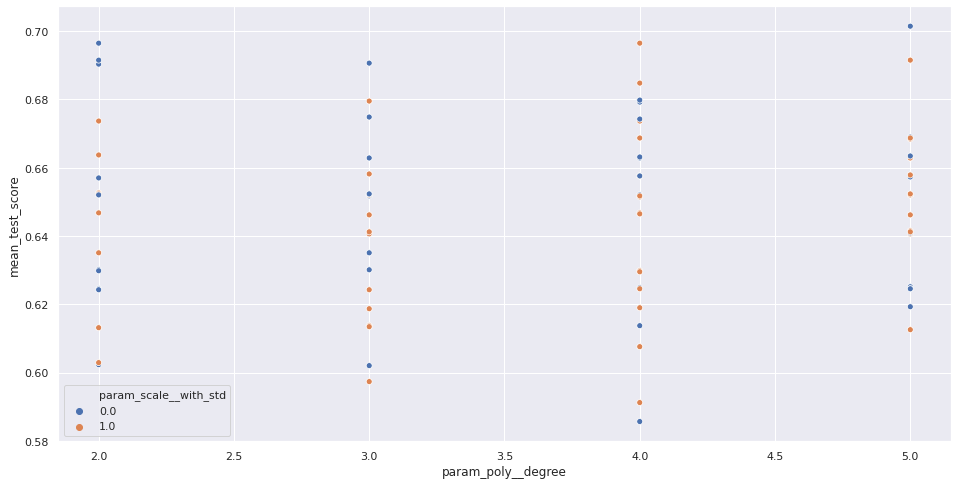

In [44]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(
    data=ada_cv_results,
    x='param_poly__degree',
    y='mean_test_score',
    hue='param_scale__with_std',
    ax=ax
)

In [46]:
joblib.dump(ada_rscv, 'ada.joblib', compress=True)

['ada.joblib']

## GB

In [331]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
#     ('scale', StandardScaler()),
    ('non_neg', MinMaxScaler()),
    ('var', VarianceThreshold()),
    ('select', SelectPercentile()),
    ('clf', GradientBoostingClassifier(random_state=0))
])

params_pre = {
#     'poly__degree' : stats.randint(2, 6),
#     'poly__interaction_only' : [True, False],
#     'poly__include_bias' : [True, False],
#     'scale__with_mean' : [True, False],
#     'scale__with_std' : [True, False],
    'var__threshold' : stats.uniform(0, 0.04),
    'select__score_func' : [f_classif, chi2, mutual_info_classif],
    'select__percentile' : stats.randint(10, 40),
}

In [432]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures()),
    ('scale', StandardScaler()),
    ('transform', ColumnTransformer(
        transformers=[('pca', PCA(n_components=1, random_state=0), X.columns.get_indexer(['bone_length', 'hair_length', 'has_soul']))],
        remainder='passthrough',
        n_jobs=-1
    )),
    ('non_neg', MinMaxScaler()),
    ('var', VarianceThreshold()),
    ('select', SelectPercentile()),
    ('clf', GradientBoostingClassifier(random_state=0))
])

params_pre = {
    'poly__degree' : stats.randint(2, 6),
    'poly__interaction_only' : [True, False],
    'poly__include_bias' : [True, False],
    'scale__with_mean' : [True, False],
    'scale__with_std' : [True, False],
    'var__threshold' : stats.uniform(0, 0.04),
    'select__score_func' : [f_classif, chi2, mutual_info_classif],
    'select__percentile' : stats.randint(10, 100),
}

In [433]:
params = [
    {
        **params_pre,
        'clf' : [OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', warm_start=False, loss='exponential', subsample=1.0, random_state=0))],
        'clf__estimator__loss' : ['deviance', 'exponential'],
        'clf__estimator__learning_rate' : stats.uniform(0.2, 1),
        'clf__estimator__n_estimators' : stats.randint(100, 1000),
        'clf__estimator__subsample' : stats.uniform(0.5, 0.5),
        'clf__estimator__criterion' : ['friedman_mse', 'mae',],
        'clf__estimator__min_samples_split' : stats.uniform(0, 0.5),
        'clf__estimator__min_samples_leaf' : stats.uniform(0, 0.15),
        'clf__estimator__min_weight_fraction_leaf' : stats.uniform(0.01, 0.15),
        'clf__estimator__max_depth' : stats.randint(3, 50),
        'clf__estimator__min_impurity_decrease' : stats.uniform(0, 0.3),
        'clf__estimator__max_features' : ['sqrt', None],
        'clf__estimator__warm_start' : [True, False],
        'clf__estimator__validation_fraction' : stats.uniform(0.14, 0.15),
        'clf__estimator__n_iter_no_change' : stats.randint(2, 10),
        'clf__estimator__tol' : stats.uniform(1e-4, 1e-1),
        'clf__estimator__ccp_alpha' : stats.uniform(0, 0.2)
    }
]

gb_rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

In [434]:
gb_rscv.fit(X_train, y_train)
print(f"Best Params")
print('-'*77)
print()
pprint(gb_rscv.best_params_)
print()
print('-'*77)
print()
print(f"Best Training Score: {gb_rscv.best_score_}")
print()
print('-'*77)
print()
print(f"Training Score: {gb_rscv.score(X_train, y_train)}")
print()
print(classification_report(y_train, gb_rscv.predict(X_train)))
print()
print('-'*77)
print()
print(f"Validation Score: {gb_rscv.score(X_validate, y_validate)}")
print()
print(classification_report(y_validate, gb_rscv.predict(X_validate)))
print()
print('-'*77)
print()
print(f"Test Score: {gb_rscv.score(X_test, y_test)}")
print()
print(classification_report(y_test, gb_rscv.predict(X_test)))
print()

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.8min finished


Best Params
-----------------------------------------------------------------------------

{'clf': OneVsRestClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.005099469793458967,
                                                         learning_rate=0.6058663838253083,
                                                         loss='exponential',
                                                         max_depth=45,
                                                         min_impurity_decrease=0.2684589576534266,
                                                         min_samples_leaf=0.00397838288984636,
                                                         min_samples_split=0.3128183086719642,
                                                         min_weight_fraction_leaf=0.12533994878422888,
                                                         n_iter_no_change=4,
                                                         random_state=0,
                               

In [435]:
gb_cv_results = pd.DataFrame(gb_rscv.cv_results_)

param_cols = gb_cv_results.columns[gb_cv_results.columns.str.contains('param')]

split_cols = gb_cv_results.columns[gb_cv_results.columns.str.contains('split')]

time_cols = gb_cv_results.columns[gb_cv_results.columns.str.contains('time')]

test_cols = gb_cv_results.columns[
    (gb_cv_results.columns.str.contains('test')) & (gb_cv_results.columns.isin(split_cols) == False)
]

param_cols = param_cols.drop([
    'params',
    'param_clf',
])

gb_cv_results = gb_cv_results.reindex(columns=param_cols.append(test_cols))

In [436]:
def cfloat(series):
    try:
        return series.astype(float)
    except Exception:
        return series

In [437]:
gb_cv_results = gb_cv_results.apply(lambda x : cfloat(x))

In [438]:
gb_cv_results.corr().mean_test_score.iloc[:-3].sort_values()

param_clf__estimator__min_weight_fraction_leaf   -0.297554
param_clf__estimator__ccp_alpha                  -0.287624
param_poly__include_bias                         -0.171215
param_select__percentile                         -0.153332
param_clf__estimator__validation_fraction        -0.090875
param_clf__estimator__warm_start                 -0.088727
param_clf__estimator__tol                        -0.083188
param_clf__estimator__min_samples_leaf           -0.063919
param_clf__estimator__n_iter_no_change           -0.038168
param_scale__with_mean                           -0.016812
param_var__threshold                             -0.015998
param_scale__with_std                            -0.012524
param_clf__estimator__min_impurity_decrease      -0.010088
param_clf__estimator__min_samples_split          -0.006663
param_poly__interaction_only                     -0.006148
param_clf__estimator__subsample                   0.041980
param_clf__estimator__max_depth                   0.1077

In [439]:
gb_cv_results.nunique(dropna=False).where(lambda x : x <= 10).dropna()

param_clf__estimator__criterion           2.0
param_clf__estimator__loss                2.0
param_clf__estimator__max_features        2.0
param_clf__estimator__n_iter_no_change    8.0
param_clf__estimator__warm_start          2.0
param_poly__degree                        4.0
param_poly__include_bias                  2.0
param_poly__interaction_only              2.0
param_scale__with_mean                    2.0
param_scale__with_std                     2.0
param_select__score_func                  3.0
dtype: float64

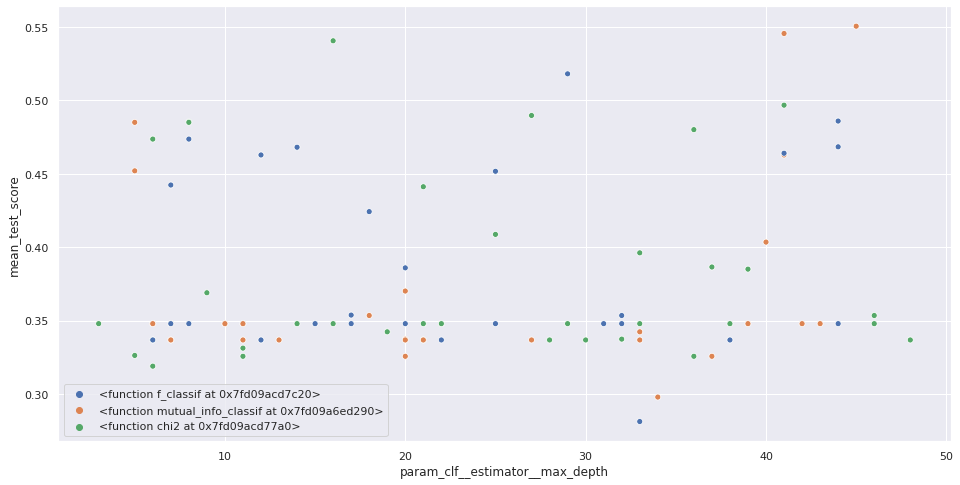

In [462]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(
    data=gb_cv_results,
    x='param_clf__estimator__max_depth',
    y='mean_test_score',
    hue=gb_cv_results.param_select__score_func.fillna('none').tolist(),
    ax=ax
)

# ax.axvline(0.14)
# ax.axvline(0.28)

param_clf__estimator__max_features
log2    AxesSubplot(0.125,0.125;0.775x0.755)
sqrt    AxesSubplot(0.125,0.125;0.775x0.755)
NaN     AxesSubplot(0.125,0.125;0.775x0.755)
Name: mean_test_score, dtype: object

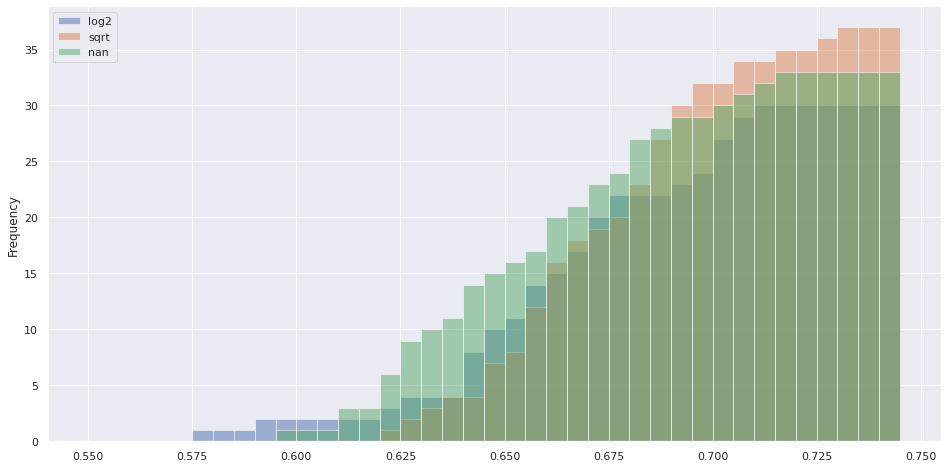

In [330]:
gb_cv_results.groupby('param_clf__estimator__max_features', dropna=False).mean_test_score.plot.hist(bins=np.arange(0.55, 0.75, 0.005),  cumulative=True, alpha=0.5, legend=True, figsize=(16,8))

In [405]:
joblib.dump(gb_rscv, 'gb.joblib', compress=True)

['gb.joblib']

# Test

In [ ]:
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import SelectPercentile, chi2, f_classif, mutual_info_classif

from functools import partial

In [ ]:
class SelectPercentileMI(SelectPercentile):
    def __init__(self, percentile=10, n_neighbors=3):
        self.n_neighbors=n_neighbors
        super().__init__(percentile=percentile,
                         score_func=partial(mutual_info_classif, n_neighbors=3))

In [ ]:
pipe = Pipeline(steps=[
    ('scale', RobustScaler()),
    ('var0', VarianceThreshold()),
    ('poly', PolynomialFeatures()),
    ('var1', VarianceThreshold()),
    ('select', 'passthrough')
])

params0 = {
    'scale__with_centering' : [True, False],
    'scale__with_scaling' : [True, False],
    'var0__threshold' : stats.uniform(0,0.5),
    'poly__degree' : stats.randint(2, 5),
    'poly__interaction_only' : [True, False],
    'poly__include_bias' : [True, False],
    'var1__threshold' : stats.uniform(0, 0.5),
}

params = [
    {
        **params0,
        'select' : [SelectPercentile()],
        'select__score_func' : [chi2, f_classif],
        'select__percentile' : stats.randint(1,100),
    },
    {
        **params0,
        'select' : [SelectPercentileMI()],
        'select__percentile' : stats.randint(1,100),
        'select__n_neighbors' : stats.randint(2,50),
    },
]